This is just a first attempt without splitting train/val/test and overfitting analysis.

### 1. Load modules

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib notebook

import koopman_probabilistic  # local file
import model_objs  # local file

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Data manipulation

1. read the data for each station, and also get the lat/long for each station
2. put the data in a time-by-stations array
3. create inputs to koopman (flatten the array above array, create associated time array, and associated covariates array)
4. rescale the data

#### 1. read the data

In [77]:
# seismometer locations
coordinates = pd.read_csv("seismometer_latlong.csv")
coordinates.index = coordinates.station
coordinate_stations = set(coordinates.station)  # not perfect overlap

In [78]:
# seismometer readings
pd_dvs = dict()
tts = dict()
min_tt = float("inf")
max_tt = 0
path = "./DVV_TEST"
for fname in os.listdir(path):
    loc = fname[3:-4]
    if loc in coordinate_stations:
        pd_dv = pd.read_csv(os.path.join(path, fname))
        tt = pd.to_datetime(pd_dv['DATE']).values.astype(np.int64) // 10 ** 9 // 60 // 60 // 24  # in days
        min_tt = min(tt[0], min_tt)
        max_tt = max(tt[-1], max_tt)


        tts[loc] = tt
        pd_dvs[loc] = pd_dv

#### 2. put it into a spatio-temporal array


In [79]:
geospatial_dv = pd.DataFrame(index=range(min_tt, max_tt + 1))
for loc in pd_dvs:
    geospatial_dv.loc[tts[loc], loc] = pd_dvs[loc].DVV.values
geospatial_dv

,BLC,BRE,BTP,CHF,CHN,DEC,DJJ,DLA,FMP,HLL,...,RSS,RUS,RVR,SPF,SRN,STG,STS,USC,WLT,WTT2
10792,NaN,NaN,-0.329190,-0.099448,NaN,NaN,-1.036003,NaN,NaN,NaN,...,-0.560826,-0.331757,-0.613812,NaN,NaN,NaN,0.809734,0.313509,NaN,NaN
10793,NaN,NaN,-0.326758,NaN,NaN,NaN,-1.373917,NaN,NaN,NaN,...,-0.636911,-0.343764,-0.504613,NaN,NaN,NaN,0.750829,0.189865,NaN,NaN
10794,NaN,NaN,-0.316481,NaN,NaN,NaN,-1.647407,NaN,NaN,NaN,...,-0.785439,-0.355583,-0.375280,NaN,NaN,NaN,0.806543,0.287139,NaN,NaN
10795,NaN,NaN,-0.307133,NaN,NaN,NaN,-1.659479,NaN,NaN,NaN,...,-0.766787,-0.353003,-0.170163,NaN,NaN,NaN,0.747892,0.120101,NaN,NaN
10796,NaN,NaN,-0.301812,NaN,NaN,NaN,-1.550634,NaN,NaN,NaN,...,-0.744009,-0.293785,-0.566000,NaN,NaN,NaN,0.763416,0.218425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18672,0.111664,-0.465278,-0.087751,0.163548,-0.370473,0.247983,-0.078991,-0.019073,0.250229,0.335587,...,0.059954,NaN,0.302296,NaN,-0.140821,0.137439,-0.568943,-0.629975,0.822324,-0.239453
18673,0.112293,-0.466423,-0.080659,0.163088,-0.376902,0.248799,-0.104236,-0.020330,0.250783,0.333295,...,0.061672,NaN,0.299823,NaN,-0.143292,0.142236,-0.573501,-0.625854,0.823090,-0.239109
18674,0.112935,-0.466805,-0.076896,0.162840,-0.383045,0.249253,-0.108748,-0.022007,0.253708,0.331143,...,0.066181,NaN,0.297007,NaN,-0.145128,0.149474,-0.573990,-0.621402,0.819695,-0.238181
18675,0.112820,-0.468786,-0.070131,0.163120,-0.384142,0.249965,-0.112154,-0.023512,0.257384,0.328415,...,0.091229,NaN,0.296794,NaN,-0.146257,0.154813,-0.576479,-0.617958,0.822271,-0.237030


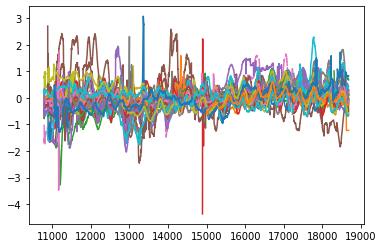

In [80]:
plt.plot(geospatial_dv);

#### 3: prepare inputs for dpk

In [103]:
data = []
tt = []
lat = []
long = []
for loc in pd_dvs:
    t = tts[loc].tolist()
    tt.extend(t)
    dv = pd_dvs[loc].DVV.values
    data.extend(dv)
    lat.extend([coordinates.loc[loc].latitude] * len(dv))
    long.extend([coordinates.loc[loc].longitude] * len(dv))
data = np.array(data).reshape(-1, 1)
tt = np.array(tt)
covars = np.array([lat, long, tt]).T  # lat, long, time (I could also put elevation or other variables like climate)

#### 4: data rescaling

In [96]:
# make sure there are no nans
np.sum(np.isnan(data)), np.sum(np.isnan(tt)), np.sum(np.isnan(covars))

(0, 0, 0)

In [113]:
scale = np.std(data)
mean = np.mean(data)
Y = (data - mean) / scale

## 3. make a geospatio-temporal model using dpk

In [99]:
# define a model
periods = [365, 365*6]  # 1 year of time period, in daily units
model_obj = model_objs.SkewNormalNLL(x_dim=Y.shape[1], num_freqs=len(periods), num_covariates=covars.shape[0])
print(model_obj)

SkewNormalNLL(
  (l1_mu): Linear(in_features=7, out_features=256, bias=True)
  (l2_mu): Linear(in_features=256, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=7, out_features=256, bias=True)
  (l2_sig): Linear(in_features=256, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=7, out_features=256, bias=True)
  (l2_a): Linear(in_features=256, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)


In [118]:
# train the model
k = koopman_probabilistic.KoopmanProb(model_obj, device='cpu')
k.init_periods(periods)
k.fit(Y, tt=tt, covariates=covars, iterations=200, weight_decay=1e-6, lr_theta=1e-4, lr_omega=0, verbose=True)  # avoid overfitting with weight_decay = 1e-4

Iteration  0
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  1.1405600342043005
Iteration  1
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  1.0489832148395
Iteration  2
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  1.0430071817061037
Iteration  3
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  1.0376021343375035
Iteration  4
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  1.0326018942822324
Iteration  5
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to 

Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.902532632862837
Iteration  46
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.9000634537480902
Iteration  47
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.8976452010978551
Iteration  48
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.894997672519397
Iteration  49
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.8923617056448058
Iteration  50
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn

Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.7300564193303367
Iteration  91
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.7273784542021653
Iteration  92
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.7246753256533094
Iteration  93
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.7220984851378455
Iteration  94
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.7195525741623233
Iteration  95
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_

Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.6216734639793816
Iteration  136
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.619788980850613
Iteration  137
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.6178659610769216
Iteration  138
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.6160271671940724
Iteration  139
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], grad_fn=<MulBackward0>)
Loss:  0.6141920488188916
Iteration  140
tensor([ 365., 2190.,  365., 2190.,  365., 2190.])
Setting periods to tensor([ 365., 2190.,  365., 2190.,  365., 2190.], g

KeyboardInterrupt: 

In [ ]:
# # Alternatively, load a pre-trained model object from a state dict
# model_obj = model_objs.SkewNormalNLL(*args, **kwargs)
# model_obj.load_state_dict(torch.load(PATH))
# model_obj.eval()  # <- this shouldn't do anything
# k = koopman_probabilistic.KoopmanProb(model_obj, device='cpu')
# k.init_periods(periods)


In [121]:
import time
import torch
torch.save(model_obj.state_dict(), f"./models/model{int(time.time())}")

## 4. Use model to predict

In [122]:
# Predict on training data
params = k.predict(T=tt, covariates=covars)
params = model_obj.rescale(mean, scale, params)
loc_hat, scale_hat, alpha_hat = params
x_hat = model_obj.mean(params)
std_hat = model_obj.std(params)

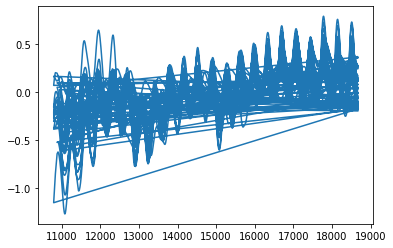

In [123]:
plt.plot(tt, x_hat)

#### make a prediction from min_tt to max_tt for each station and animate the results!

In [128]:
from matplotlib import animation

In [125]:
all_time = geospatial_dv.index.values
station_preds = pd.DataFrame()
for station in pd_dvs:
    lat = [coordinates.loc[station].latitude] * len(all_time)
    long = [coordinates.loc[station].longitude] * len(all_time)
    c = np.array([lat, long, all_time]).T
    
    params = k.predict(T=all_time, covariates=c)
    params = model_obj.rescale(mean, scale, params)
    loc_hat, scale_hat, alpha_hat = params
    x_hat = model_obj.mean(params)
    std_hat = model_obj.std(params)
    station_preds[station] = x_hat[:, 0]

In [164]:
station_lats = np.array([coordinates.loc[s].latitude for s in station_preds.columns])
station_longs = np.array([coordinates.loc[s].longitude for s in station_preds.columns])
minp = min(station_preds.min())
maxp = max(station_preds.max())

def station_frame(i):
    colors = (station_preds.iloc[i] - minp) / (maxp - minp)
    plt.scatter(station_longs, station_lats, c=colors)
    plt.title(f"year={round((all_time[i] - all_time[0]) / 365.24, 1)}")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
def blank():
    plt.plot([])

MovieWriter ffmpeg unavailable; using Pillow instead.


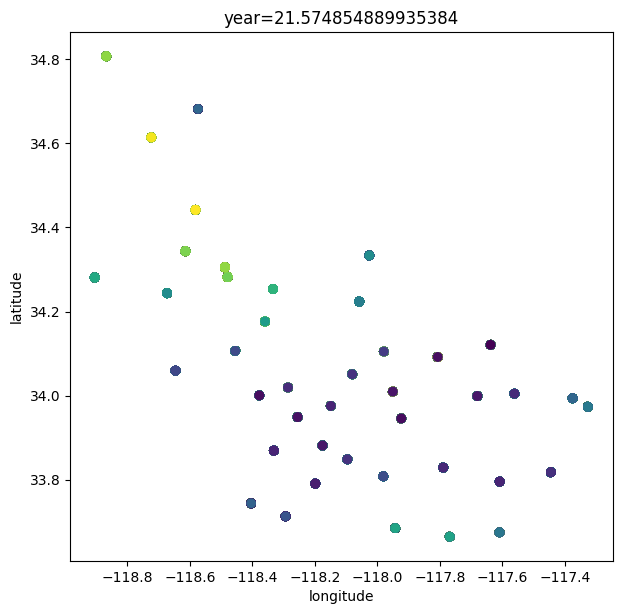

In [165]:
fig = plt.figure(dpi=100, figsize=(7, 7))
anim = animation.FuncAnimation(fig, func=station_frame, init_func=blank, frames=np.arange(0, len(all_time), 40), interval=200)
anim.save(f'stations{int(time.time())}.gif')

#### make a prediction from min_tt to max_tt for a meshgrid of locations

In [218]:
model_obj.eval()
with torch.no_grad():

    lat_samples, lat_step = np.linspace(coordinates.latitude.min(), coordinates.latitude.max(), 128, endpoint=False, retstep=True)
    lat_linspace = lat_samples + lat_step / 2
    long_samples, long_step = np.linspace(coordinates.longitude.min(), coordinates.longitude.max(), 128, endpoint=False, retstep=True)
    long_linspace = long_samples + long_step / 2
    spatial_preds = np.empty((len(lat_linspace), len(long_linspace), len(all_time)), dtype=np.float32)
    for i, lat in enumerate(lat_linspace):
        for j, long in enumerate(long_linspace):
            c = np.array([[lat] * len(all_time), [long] * len(all_time), all_time]).T

            params = k.predict(T=all_time, covariates=c)
            params = model_obj.rescale(mean, scale, params)
            loc_hat, scale_hat, alpha_hat = params
            x_hat = model_obj.mean(params)
            std_hat = model_obj.std(params)
            spatial_preds[i, j, :] = x_hat[:, 0]

model_obj.train()

SkewNormalNLL(
  (l1_mu): Linear(in_features=7, out_features=256, bias=True)
  (l2_mu): Linear(in_features=256, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=7, out_features=256, bias=True)
  (l2_sig): Linear(in_features=256, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=7, out_features=256, bias=True)
  (l2_a): Linear(in_features=256, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)

In [246]:
minp = np.min(spatial_preds)
maxp = np.max(spatial_preds)
def blank_colorbar():
    plt.imshow(np.zeros((len(long_samples), len(lat_samples))), vmin=minp, vmax=maxp, extent=(long_samples[0], long_samples[-1] + long_step, lat_samples[0], lat_samples[-1] + lat_step))
    plt.colorbar()

def spatial_frame(i):
    plt.imshow(spatial_preds[:, :, i], origin="lower", vmin=minp, vmax=maxp, extent=(long_samples[0], long_samples[-1] + long_step, lat_samples[0], lat_samples[-1] + lat_step), alpha=0.9)
    plt.scatter(station_longs, station_lats, c=geospatial_dv.iloc[i], vmin=minp, vmax=maxp)
    plt.title(f"year={round((all_time[i] - all_time[0]) / 365.24, 1)}")
    plt.xlabel("longitude")
    plt.ylabel("latitude")

MovieWriter ffmpeg unavailable; using Pillow instead.


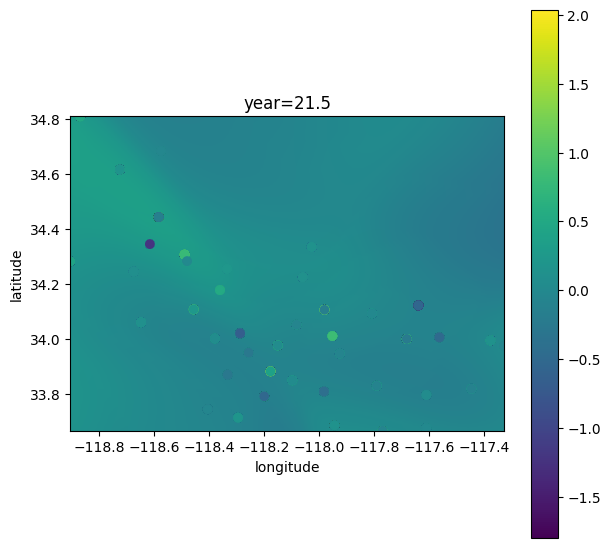

In [249]:
fig = plt.figure(dpi=100, figsize=(7, 7))
anim = animation.FuncAnimation(fig, func=spatial_frame, init_func=blank_colorbar, frames=np.arange(0, len(all_time), 50), interval=250)
anim.save(f'spatial{int(time.time())}.gif')

#### view all the individual forecasts

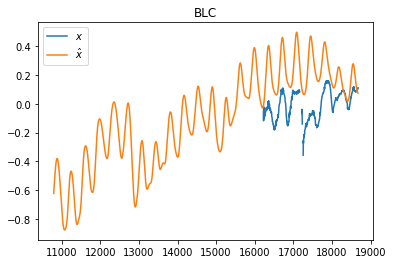

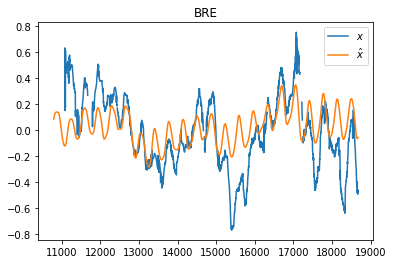

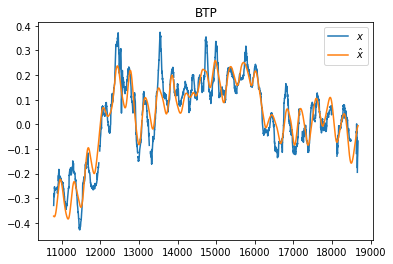

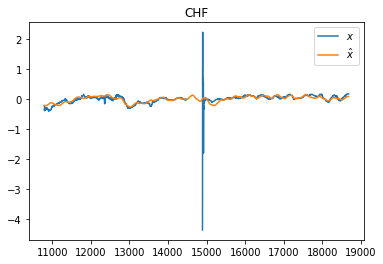

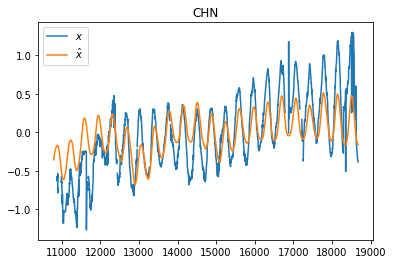

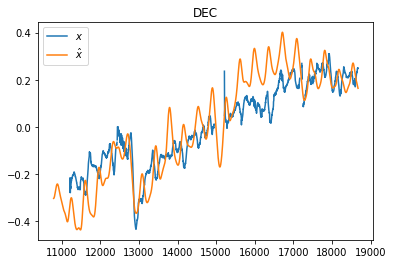

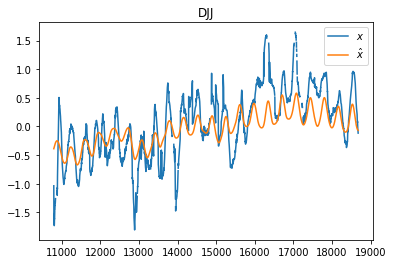

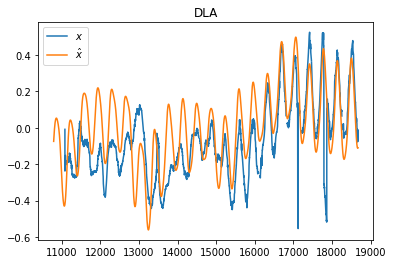

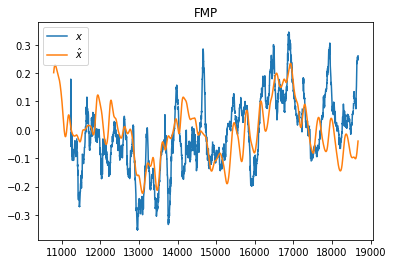

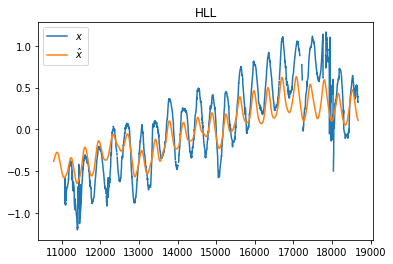

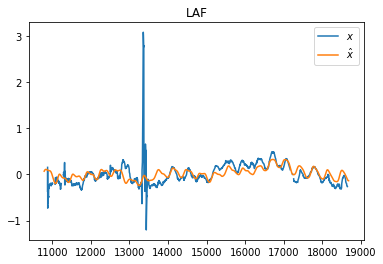

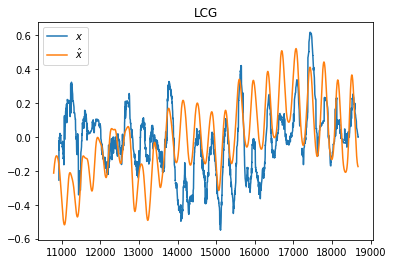

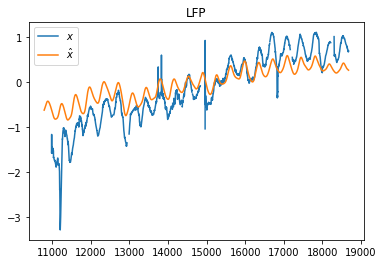

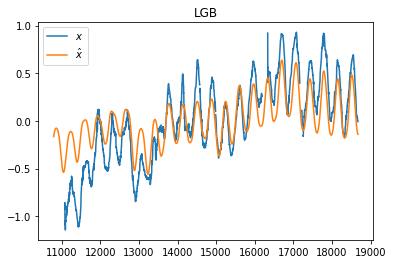

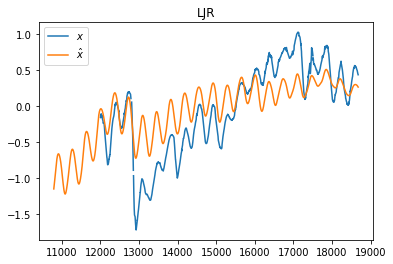

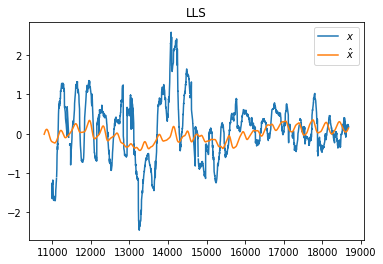

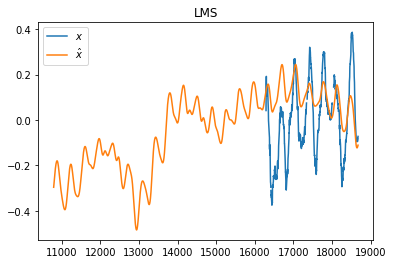

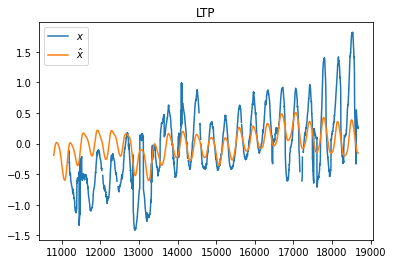

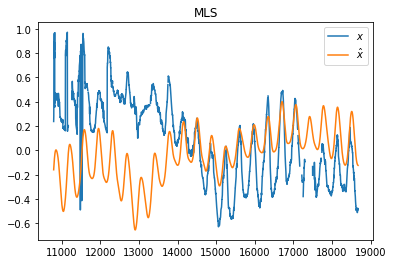

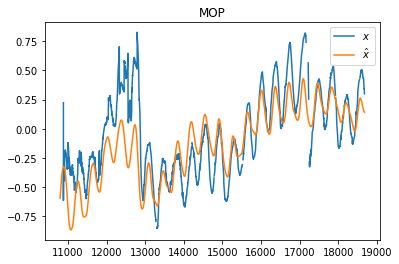

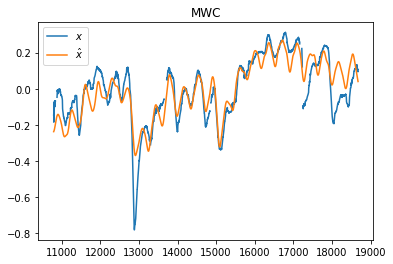

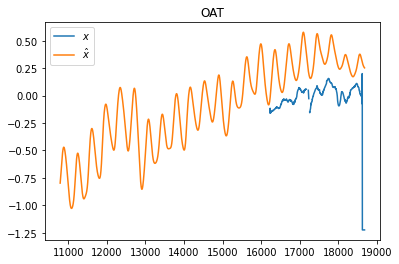

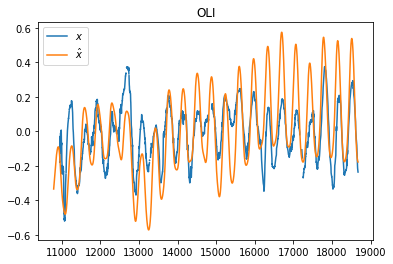

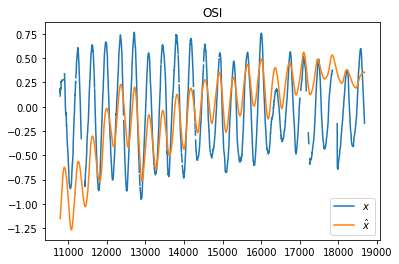

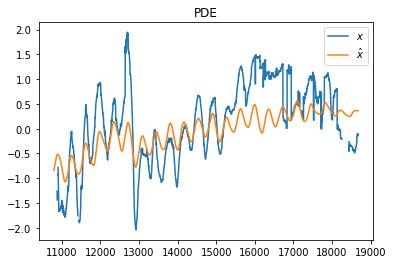

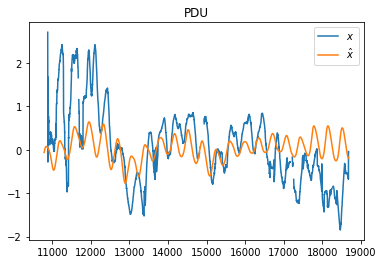

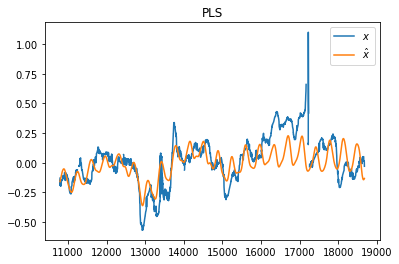

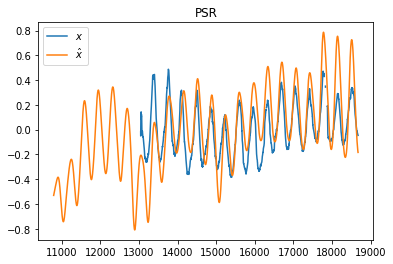

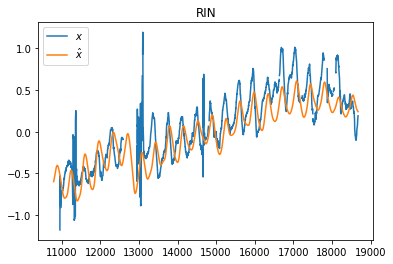

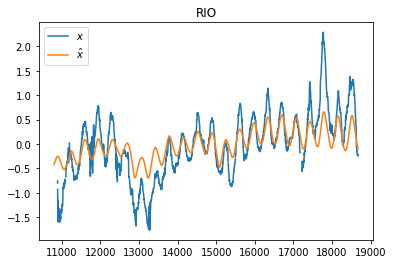

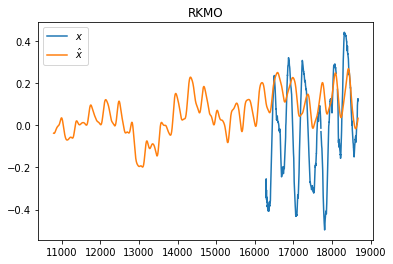

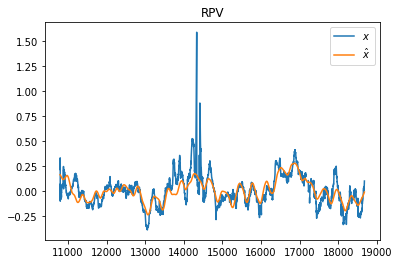

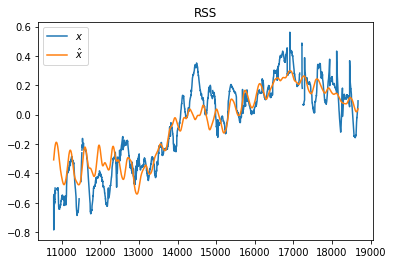

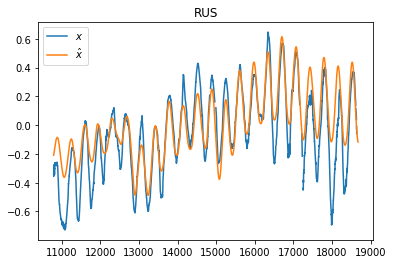

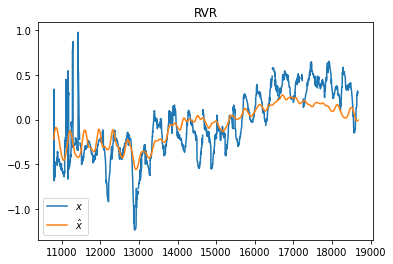

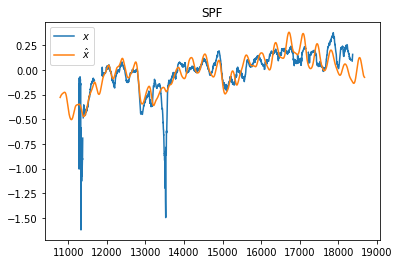

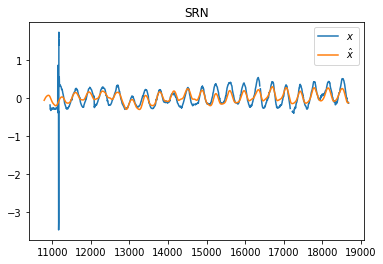

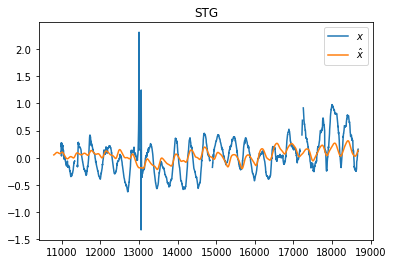

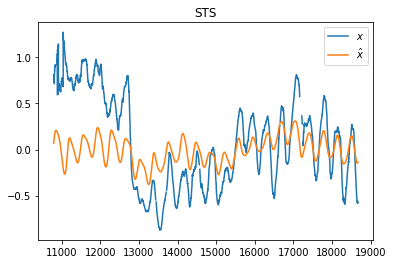

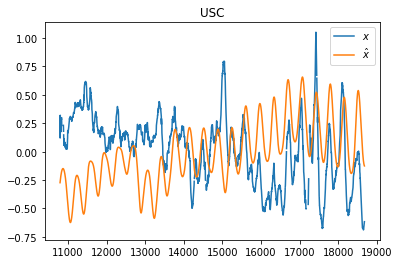

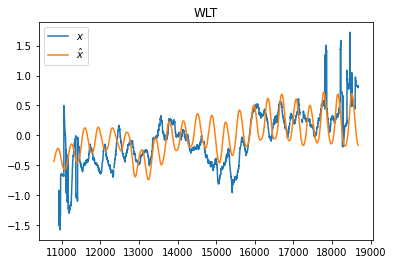

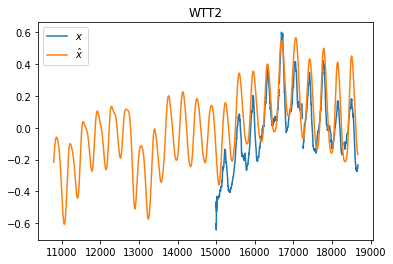

In [178]:
for station in station_preds:
    plt.title(station)
    plt.plot(all_time, geospatial_dv[station], label="$x$")
    plt.plot(all_time, station_preds[station], label="$\hat x$")
    plt.legend()
    plt.show()

In [179]:
coordinates

,network,station,latitude,longitude,elevation
station,,,,,
BLC,CI,BLC,34.24356,-118.67312,607
BRE,CI,BRE,33.80776,-117.98116,24
BTP,CI,BTP,34.68224,-118.57398,1702
CHF,CI,CHF,34.33341,-118.02585,1594
CHN,CI,CHN,33.99879,-117.68044,208
CPPC,ZY,CPPC,34.05467,-117.83020,0
DEC,CI,DEC,34.25353,-118.33383,519
DJJ,CI,DJJ,34.10618,-118.45505,268
DJJB,CI,DJJB,34.10618,-118.45505,268
